# Package Imports

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import string
import os
import pickle
from nltk.stem.porter import PorterStemmer

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import GridSearchCV

# 20 News Groups

## Data Exploration

In [2]:
twenty_train = fetch_20newsgroups(subset='train', shuffle=True, 
                                  remove=(['headers', 'footers', 'quotes']))

In [3]:
twenty_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [4]:
len(twenty_train.data)
#Number of examples

11314

([<matplotlib.axis.XTick at 0x1b036721cc8>,
 <a list of 20 Text xticklabel objects>)

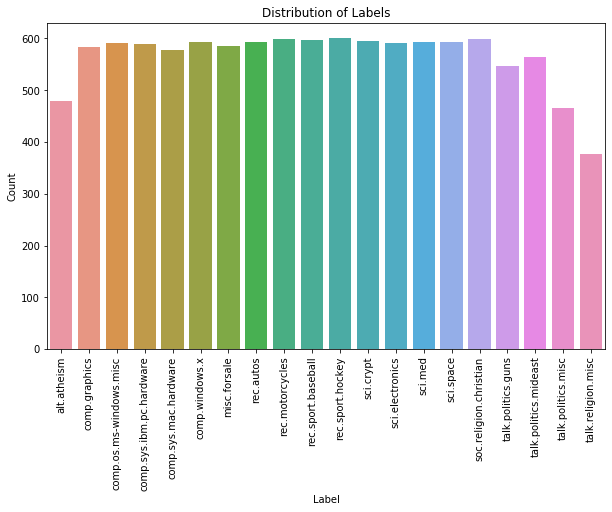

In [46]:
plt.figure(figsize=(10, 6))
sns.countplot(twenty_train.target)
plt.title("Distribution of Labels")
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks(np.arange(20), twenty_train.target_names, rotation="vertical")
#Fairly even distribution of labels, with a bit less in the "talk" categories

In [47]:
twenty_train.data[0:5]
#EXAMPLES

['I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.',
 "A fair number of brave souls who upgraded their SI clock oscillator have\nshared their experiences for this poll. Please send a brief message detailing\nyour experiences with the procedure. Top speed attained, CPU rated speed,\nadd on cards and adapters, heat sinks, hour of usage per day, floppy disk\nfunctionality with 800 and 1.4 m floppies are especially requested.\n\nI will be summarizing in the next two days, so please add to the network\nknowledge base if you have done the clock upgrade and haven't an

In [48]:
for i in range(3):
    print(twenty_train.target_names[twenty_train.target[i]])
#Corresponding labels

rec.autos
comp.sys.mac.hardware
comp.sys.mac.hardware


## Functions

In [5]:
def preprocess_news_data(data):
    '''Strips, removes punctuation, and converts each string to lowercase.
    
    Keyword Arguments: 
    
    data (list): list of strings
    
    Returns:
    
    list: processed list of strings
    
    '''
    spaces = re.compile(r"(\n)|(\.)|(@)")#newlines, dots and @ for e-mails
    data = [spaces.sub(" ", review).lower().strip() for review in data] #re sub, lowercase and stripping
    data = [review.translate(str.maketrans('', '', string.punctuation)) for review in data] #removing all remaining punctuation
    return data

In [6]:
def stem_data(data):
    """Reduce words to their stem using the Porter algorithm from nltk.
    
    Keyword Arguments:
    
    data (list of strings): textual data in a list
    
    
    Returns:
    
    (list of strings): data where each word is stemmed"""
    porter = PorterStemmer()
    stemmed_data = []
    for d in data:
        stemmed_data.append(" ".join([porter.stem(word) for word in d.split()]))
    return stemmed_data

In [7]:
def fetch_news(test=False):
    '''Fetches and processes data and labels for 20 newsgroups dataset
    
    Keyword Arguments: 
    
    test (bool): indicates test (True) or train (False) subset to fetch
    
    Returns:
    
    X (list): processed data
    y (nparray): one hot encoded labels for each example in the data
    
    '''
    if test:
        subset = 'test' 
    else:
        subset = 'train'
    
    data = fetch_20newsgroups(subset=subset, shuffle=True,
                                 remove=(['headers', 'footers', 'quotes']))
    
    X = preprocess_news_data(data.data)
    X = stem_data(X)
    y = data.target.reshape(-1, 1)
    return X, y

## Testing Functions

In [62]:
X_train, y_train = fetch_news()

In [63]:
y_train.shape

(11314, 20)

In [64]:
X_train[0:5]

['i wa wonder if anyon out there could enlighten me on thi car i saw the other day it wa a 2door sport car look to be from the late 60 earli 70 it wa call a bricklin the door were realli small in addit the front bumper wa separ from the rest of the bodi thi is all i know if anyon can tellm a model name engin spec year of product where thi car is made histori or whatev info you have on thi funki look car pleas email',
 'a fair number of brave soul who upgrad their si clock oscil have share their experi for thi poll pleas send a brief messag detail your experi with the procedur top speed attain cpu rate speed add on card and adapt heat sink hour of usag per day floppi disk function with 800 and 1 4 m floppi are especi request i will be summar in the next two day so pleas add to the network knowledg base if you have done the clock upgrad and havent answer thi poll thank',
 'well folk my mac plu final gave up the ghost thi weekend after start life as a 512k way back in 1985 sooo im in the 

# Movie Reviews

## Functions

In [8]:
def fetch_from_dir(directory):
    """Given a directory, reads all text files into a list
    
    Parameters:
    
    directory (string): A directory path to search inside. E.g. 'C://code//data' 
    
    Returns:
    
    list: strings parsed from each text file in directory
    """
    data = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.txt'):
                with open(os.path.join(root, file), 'r', encoding='utf8') as f:
                    text = f.read()
                    data.append(text)
                
    return data

In [9]:
def preprocess_movie_data(data):   
    """Removes unwanted HTML tags, converts to lowercase, strips, and removes punctuation in a list of strings
    
    Parameters:
    
    data: list of strings to clean
    
    Returns:
    
    list: processed data
    """
    
    br_tags = re.compile(r"<br\s*/>")#br tag with any number of spaces inside
    data = [br_tags.sub(" ", review).strip().lower() for review in data]
    data = [review.translate(str.maketrans('', '', string.punctuation)) for review in data]
    
    return data

In [10]:
def fetch_movie(base_directory, test=False):
    """Generates cleaned movie review data and labels
    
    Parameters:
    
    base_directory: base directory for the movie review dataset
                
                Assumes that directory has original structure:
                
                    base_directory
                        train
                            pos
                            neg
                        test
                            pos
                            neg
                            
    test: specifies whether to load train (False) or test (True) data
    
    
    Returns:
    
    X (list): processed data
    y (nparray): binary labels for each example in X
    """
    
    if test:
        base_directory = base_directory + "//test"
    else:
        base_directory = base_directory + "//train"
    
    X = fetch_from_dir(base_directory + "//pos")
    X.extend(fetch_from_dir(base_directory + "//neg"))
    y = [1 if i < len(X)/2 else 0 for i in range(len(X))]
    
    y = np.array(y).reshape(-1, 1)
    
    X = preprocess_movie_data(X)
    X = stem_data(X)
    
    return X, y

## Testing Functions

In [68]:
X_train = fetch_from_dir("C://code//educational//comp551//mini2//aclImdb//train//pos")
X_train.extend(fetch_from_dir("C://code//educational//comp551//mini2//aclImdb//train//neg"))
X_train[0:5]
#Examples of reviews

['Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as "Teachers". My 35 years in the teaching profession lead me to believe that Bromwell High\'s satire is much closer to reality than is "Teachers". The scramble to survive financially, the insightful students who can see right through their pathetic teachers\' pomp, the pettiness of the whole situation, all remind me of the schools I knew and their students. When I saw the episode in which a student repeatedly tried to burn down the school, I immediately recalled ......... at .......... High. A classic line: INSPECTOR: I\'m here to sack one of your teachers. STUDENT: Welcome to Bromwell High. I expect that many adults of my age think that Bromwell High is far fetched. What a pity that it isn\'t!',
 'Homelessness (or Houselessness as George Carlin stated) has been an issue for years but never a plan to help those on the street that were once considered human who did everything fro

In [69]:
X_train, y_train = fetch_movie("C://code//educational//comp551//mini2//aclImdb")

In [70]:
y_train.shape

(25000, 1)

In [71]:
X_train[0:5]
#noticeably cleaner than before

['bromwel high is a cartoon comedi it ran at the same time as some other program about school life such as teacher my 35 year in the teach profess lead me to believ that bromwel high satir is much closer to realiti than is teacher the scrambl to surviv financi the insight student who can see right through their pathet teacher pomp the petti of the whole situat all remind me of the school i knew and their student when i saw the episod in which a student repeatedli tri to burn down the school i immedi recal at high a classic line inspector im here to sack one of your teacher student welcom to bromwel high i expect that mani adult of my age think that bromwel high is far fetch what a piti that it isnt',
 'homeless or houseless as georg carlin state ha been an issu for year but never a plan to help those on the street that were onc consid human who did everyth from go to school work or vote for the matter most peopl think of the homeless as just a lost caus while worri about thing such as 

In [72]:
y_train[0:5]

array([[1],
       [1],
       [1],
       [1],
       [1]])

# Generating Features

In [11]:
X_news_train, y_news_train = fetch_news()
X_news_test, y_news_test = fetch_news(test=True)

base_directory = "C://code//educational//comp551//mini2//aclImdb"
X_movie_train, y_movie_train = fetch_movie(base_directory)
X_movie_test, y_movie_test = fetch_movie(base_directory, test=True)

In [14]:
fifty_common_words = [
    'the', 'of', 'and', 'a', 'to', 'in', 'is', 'you', 'that', 'it',
    'he', 'was', 'for', 'on', 'are', 'as', 'with', 'his', 'they', 'i',
    'at', 'be', 'this', 'have', 'from', 'or', 'one', 'had', 'by', 'word',
    'but', 'not', 'what', 'all', 'were', 'we', 'when', 'your', 'can', 'said',
    'there', 'use', 'an', 'each', 'which', 'she', 'do', 'how', 'their', 'if'
]

#fifty most common words in english language; use as stop words.
#https://www.rypeapp.com/most-common-english-words/


# Gives a normalized word frequency vector, multiplied by inverse document frequency
# Try four different combinations
# Binary: use one-hot encoding instead of word frequency
# N-grams: permit use of two word-sequences in addition to individual words. i.e. "very bad" can be a single term

# To minimize vocabulary, in addition to removing stop words we only keep words used in less than 90% of documents, and
# used in at least 1% of all documents.

text_features = Pipeline([
    ('vectorize', CountVectorizer(max_features=None, max_df=0.9, min_df=5, 
                                  stop_words=fifty_common_words, binary=False, ngram_range=(1, 1))),
    ('tfidf', TfidfTransformer(use_idf=True, norm='l2'))
])

text_features_ngrams = Pipeline([
    ('vectorize', CountVectorizer(max_features=None, max_df=0.9, min_df=5, 
                                  stop_words=fifty_common_words, binary=False, ngram_range=(1, 3))),
    ('tfidf', TfidfTransformer(use_idf=True, norm='l2'))
])


text_features_binary = Pipeline([
    ('vectorize', CountVectorizer(max_features=None, max_df=0.9, min_df=5, 
                                  stop_words=fifty_common_words, binary=True, ngram_range=(1, 1))),
    ('tfidf', TfidfTransformer(use_idf=True, norm='l2'))
])


text_features_binary_ngrams = Pipeline([
    ('vectorize', CountVectorizer(max_features=None, max_df=0.9, min_df=5, 
                                  stop_words=fifty_common_words, binary=True, ngram_range=(1, 3))),
    ('tfidf', TfidfTransformer(use_idf=True, norm='l2'))
])

In [15]:
def transform_and_save(filename, X_train, X_test, y_train, y_test, pipeline):
    X_train_proc = pipeline.fit_transform(X_train)
    X_test_proc = pipeline.transform(X_test)
    with open(filename, 'wb') as f:
        pickle.dump([X_train_proc, y_train, X_test_proc, y_test], f)
        

        
transform_and_save("news.pkl", X_news_train, X_news_test, y_news_train, y_news_test, text_features)    
transform_and_save("news_binary.pkl", X_news_train, X_news_test, y_news_train, y_news_test, text_features_binary)    
transform_and_save("news_ngrams.pkl", X_news_train, X_news_test, y_news_train, y_news_test, text_features_ngrams)    
transform_and_save("news_binary_ngrams.pkl", X_news_train, X_news_test, y_news_train, y_news_test, text_features_binary_ngrams)    
transform_and_save("movie.pkl", X_movie_train, X_movie_test, y_movie_train, y_movie_test, text_features)    
transform_and_save("movie_binary.pkl", X_movie_train, X_movie_test, y_movie_train, y_movie_test, text_features_binary)    
transform_and_save("movie_ngrams.pkl", X_movie_train, X_movie_test, y_movie_train, y_movie_test, text_features_ngrams)    
transform_and_save("movie_binary_ngrams.pkl", X_movie_train, X_movie_test, y_movie_train, y_movie_test, text_features_binary_ngrams)    

In [16]:
ex = text_features.fit_transform(X_movie_train)

In [17]:
text_features.steps[0][1].get_feature_names()

['00',
 '007',
 '01',
 '010',
 '02',
 '05',
 '06',
 '07',
 '10',
 '100',
 '1000',
 '10000',
 '100000',
 '1000000',
 '101',
 '1010',
 '1015',
 '102',
 '103',
 '104',
 '105',
 '107',
 '108',
 '10th',
 '10yearold',
 '11',
 '110',
 '1100',
 '112',
 '116',
 '11th',
 '11year',
 '11yearold',
 '12',
 '120',
 '1200',
 '12000000',
 '123',
 '12th',
 '12year',
 '12yearold',
 '13',
 '1300',
 '1331',
 '135',
 '13th',
 '13yearold',
 '14',
 '140',
 '14th',
 '14year',
 '14yearold',
 '15',
 '150',
 '1500',
 '1520',
 '15minut',
 '15th',
 '15year',
 '16',
 '160',
 '1600',
 '169',
 '16mm',
 '16th',
 '17',
 '1700',
 '17th',
 '18',
 '180',
 '1800',
 '1830',
 '1840',
 '1850',
 '1851',
 '1876',
 '1880',
 '1890',
 '1895',
 '1898',
 '18th',
 '19',
 '1900',
 '1902',
 '1909',
 '1910',
 '1912',
 '1913',
 '1914',
 '1915',
 '1916',
 '1917',
 '1918',
 '1919',
 '1920',
 '1921',
 '1922',
 '1924',
 '1925',
 '1926',
 '1927',
 '1928',
 '1929',
 '1930',
 '1931',
 '1932',
 '1933',
 '1934',
 '1935',
 '1936',
 '1937',
 '1938',

In [18]:
ex.shape

(25000, 19604)

In [19]:
ex2 = text_features_ngrams.fit_transform(X_news_train)

In [20]:
ex2.shape

(11314, 40585)

In [21]:
text_features_ngrams.steps[0][1].get_feature_names()

['00',
 '00 00',
 '00 01',
 '00 10',
 '00 first',
 '00 more',
 '00 ship',
 '000',
 '0000',
 '0002',
 '001',
 '001 rz350',
 '01',
 '010',
 '014',
 '016',
 '02',
 '020',
 '02106',
 '02106 chopin',
 '02106 chopin udel',
 '02139',
 '03',
 '030',
 '04',
 '040',
 '05',
 '0500',
 '06',
 '060',
 '07',
 '08',
 '0863',
 '0863 id',
 '0863 id squid',
 '09',
 '0a',
 '0b0',
 '0b0 unregist',
 '0b0 unregist evalu',
 '0c',
 '0h',
 '0l',
 '0s',
 '0x',
 '10',
 '10 00',
 '10 10',
 '10 11',
 '10 12',
 '10 14',
 '10 15',
 '10 20',
 '10 22',
 '10 30',
 '10 86',
 '10 billion',
 '10 day',
 '10 million',
 '10 minut',
 '10 peopl',
 '10 percent',
 '10 so',
 '10 time',
 '10 year',
 '10 year ago',
 '100',
 '100 00',
 '100 feet',
 '100 million',
 '100 peopl',
 '100 so',
 '100 watt',
 '100 year',
 '1000',
 '1000 peopl',
 '1000 year',
 '10000',
 '100000',
 '1000000',
 '1006',
 '100k',
 '101',
 '1010',
 '1012',
 '1013',
 '1014',
 '1015',
 '1019',
 '102',
 '102 18',
 '1020',
 '1024',
 '1024x768',
 '1024x768x256',
 '1025